In [1]:
from mqt.bench import get_benchmark
from qiskit import QuantumCircuit, Aer, execute, assemble
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.compiler import transpile
from qiskit.visualization import plot_gate_map
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import time
import os
from statistics import mean
import matplotlib.pyplot as plt
import re
import csv
from collections import OrderedDict
import warnings

from quantumCircuits import buildQC

# This bypasses the runtime warnings in the terminal
warnings.filterwarnings("ignore")


def file_reader(file_path):
    """ 
    This is the path to the quantum circuits stored from a specified directory and is responsible for 
    returning a list of QuantumCircuit objects along with a list of the order in which they were read.

    Parameters
    ----------
    file_path : str -> The path to the directory containing .qasm files.
    
    Returns
    -------
    circuits : tuple -> A list of QuantumCircuit objects read from the QASM files
    file_order : tuple -> A list of file names in the order they were read from the circuits in the first list.
    """  
    
    def ascending_sort(circuits):
        """ 
        This sorts our list of circuits in ascending order based on the numeric values within each string of its name 

        Parameters
        ----------
        circuits : list -> A list of quantum circuits names to be sorted
        
        Returns
        -------
        split : list -> A list of sorted circuit names with numeric segments sorted in ascending order.
        """

        num = re.compile(r'(\d+)')
        split = num.split(circuits)
        split[1::2] = map(int, split[1::2])
        return split

    circuits = []
    file_order = []
    directory = file_path
    for circuit in sorted(os.listdir(directory), key=ascending_sort):
        circuit_path = f"{file_path}/{circuit}"
        if(circuit_path.endswith('.qasm')):
            print(circuit_path)
            qc = QuantumCircuit.from_qasm_file(circuit_path)
            # Gets the name of each circuit in the order it's read
            file_order.append(circuit)
            circuits.append(qc)
    return circuits, file_order

In [2]:
def runtime_benchmarking(NUM_ITERATIONS, circuits, the_backend):
    """ 
    This function benchmarks the runtime of transpilation for a list of quantum circuits on the different
    optimization levels (0, 1, 2, and 3). It calculates and displays the average runtime and creates
    a graph to visualize the runtime trends for each optimization level.

    Parameters
    ----------
    NUM_ITERATIONS : int -> The number of iterations for benchmarking each circuit
    circuits : list -> A list of quantum circuits we want to benchmark
    the_backend : backend -> The backend to used for transpilation

    Returns
    -------
    Optimization_Levels : tuple -> A dictionary of transpiled circuits grouped by optimization level.
    ttime_level1, ttime_level2, ttime_level3 : tuplw -> Lists of runtime data for each optimization level.
    mean_transpile_times_1, mean_transpile_times_2, mean_transpile_times_3: tuple -> Lists of mean transpile times for each optimization level.
    """

    BACKEND = the_backend
    Optimization_Levels = {3: [], 2: [], 1: [], 0: []}

    #These array will store:
    mean_transpile_times_1 = []
    mean_transpile_times_2 = []
    mean_transpile_times_3 = []
    
    ttime_level1 = []
    ttime_level2 = []
    ttime_level3 = []
    
    for counter, circuit in enumerate(circuits):
        transpiled = False
        temp1 = []
        temp2 = []
        temp3 = []
        for _ in range(NUM_ITERATIONS):
            #Transpilation Level 1:
            start_time = time.perf_counter()
            qc1 = transpile(circuit, optimization_level= 1, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            temp1.append(stop_time - start_time)
            #Transpilation Level 2:
            start_time = time.perf_counter()
            qc2 = transpile(circuit, optimization_level= 2, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            temp2.append(stop_time - start_time)
            #Transpilation Level 3:
            start_time = time.perf_counter()
            qc3 = transpile(circuit, optimization_level= 3, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            temp3.append(stop_time - start_time)
            #If this is the first iteration, then we simply add the circuits to the dictonary
            if transpiled == False:
                Optimization_Levels[3].append(qc3)
                Optimization_Levels[2].append(qc2)
                Optimization_Levels[1].append(qc1)
                Optimization_Levels[0].append(circuit)
                transpiled = True
        #At this point all the data has been added to iteration_times. Now it is just a matter of extracting data.
        ttime_level1.append(temp1)
        ttime_level2.append(temp2)
        ttime_level3.append(temp3)
        
        mean_transpile_times_1.append(mean(temp1))
        mean_transpile_times_2.append(mean(temp2))
        mean_transpile_times_3.append(mean(temp3))
        print("Circuit Index Completed: ", counter)
        
    #Scatter Plot for Runtime after all values are collected
    plt.figure(figsize=(12, 6))
    #Number of qubits in the sorted circuit
    number_of_qubits = [i + 2 for i in range(len(mean_transpile_times_1))] #num of qubits
    x = np.array(number_of_qubits)
    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(mean_transpile_times_1), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(mean_transpile_times_2), 1)
    #Calculating Line of BEST Fit: Optimization Level 3
    e, f = np.polyfit(x, np.array(mean_transpile_times_3), 1)
    plt.scatter(number_of_qubits, mean_transpile_times_1, label = "Average of Opt Level 1")
    plt.plot(x, a*x+b)
    plt.scatter(number_of_qubits, mean_transpile_times_2, label = "Average of Opt Level 2")
    plt.plot(x, c*x+d)
    plt.scatter(number_of_qubits, mean_transpile_times_3, label = "Average of Opt Level 3")
    plt.plot(x, e*x+f)
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime in Seconds')
    plt.title('Runtime in Seconds (at each opt level)')
    plt.legend()
    plt.show()
    
    print("mean 1", mean_transpile_times_1)
    print("mean 2", mean_transpile_times_2)
    print("mean 3", mean_transpile_times_3)
    
    return Optimization_Levels, ttime_level1, ttime_level2, ttime_level3, mean_transpile_times_1, mean_transpile_times_2, mean_transpile_times_3

In [9]:
def gate_count(optimization_levels):
    """
    This function is responsible for counting and visualizing the number of gates for the transpiled
    circuits at each optimization levels. It then returns the lists containing the gate counts
    for each circuit at each optimization level.
    Parameters
    ----------
    optimization_levels : dict -> A dictionary containing the lists of transpiled circuits for each optimization level
    Returns
    -------
    opt1, opt2, opt3 : list -> A list containing lists of gate counts for each optimization level
    """
    # Transpile each circuit, count the gates, and store the results
    opt1 = []
    opt2 = []
    opt3 = []
    
    for i in range(len(optimization_levels[1])):
        # Counts the number of gates in a circuit given its respective optimization level
        opt1_count = optimization_levels[1][i].count_ops()
        opt2_count = optimization_levels[2][i].count_ops()
        opt3_count = optimization_levels[3][i].count_ops()
        # Appends our count of the transpiled circuit to the array
        opt1.append(sum(opt1_count.values()))
        opt2.append(sum(opt2_count.values()))
        opt3.append(sum(opt3_count.values()))
        
    number_of_qubits = [i + 2 for i in range(len(optimization_levels[1]))]
    
    # Generate a graph to visualize the gate counts for each optimization levels
    plt.plot(number_of_qubits, opt1, label = "Optimization Level 1")
    plt.plot(number_of_qubits, opt2, label = "Optimization Level 2")
    plt.plot(number_of_qubits, opt3, label = "Optimization Level 3")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Gate Count')
    plt.title('Gate Count of Transpiled Circuits')
    plt.legend()
    plt.show()
    print("gate count level 1", opt1)
    print("gate count level 2", opt2)
    print("gate count level 3", opt3)
    return opt1, opt2, opt3

In [4]:
def single_multi_ratio_benchmarking(optimization_levels):
    """ 
    This fucntion is responible calculating and visualizing the ratio of single-qubit to multi-qubit gates for
    each optimization level of transpiled quantum circuits. It returns lists containing the ratios
    for each optimization level.

    Parameters
    ----------
    optimization_levels : dict -> A dictionary containing the lists of transpiled circuits for each optimization level 

    Returns
    -------
    level1_list, level2_list, level3_list : tuple -> A tuple containing the lists of single-multi qubit ratios for each optimization level
    """ 
    
    def num_single_and_multi_qubit_gates(circuit):
        """ 
        This function counts the number of single-qubit and multi-qubit gates in a given quantum circuit.
        It returns a dictionary containing the counts for each type.

        Parameters
        ----------
        circuit : Quantum Circuit -> The quantum circuit who's single-qubit and multi-qubit gates you want to count

        Returns
        -------
        Map : dict -> A dictionary containing the count of single-qubit and multi-qubit gates.
        """ 
        
        Map = {'single' : 0, "multi" : 0}
        for gate in circuit.data:
            if len(gate[1]) == 1:
                Map['single'] = Map['single'] + 1
            else:
                Map['multi'] = Map['multi'] + 1
        return Map

    # These lists will store the ratios (single // Multi ) of each circuit
    level1_list = []
    level2_list = []
    level3_list = []    
    
    for i in range(len(optimization_levels[1])):
        
        level1_data = num_single_and_multi_qubit_gates(optimization_levels[1][i])
        level2_data = num_single_and_multi_qubit_gates(optimization_levels[2][i])
        level3_data = num_single_and_multi_qubit_gates(optimization_levels[3][i])
        
        #Step 3: Prepare ratio and list that contains all the data
        if level1_data['multi'] > 0:
            level1_ratio = level1_data['single'] / level1_data['multi']
            level1_list.append(level1_ratio)
        else:
            level1_list.append(level1_data['single'])
            
        if level2_data['multi'] > 0:
            level2_ratio = level2_data['single'] / level2_data['multi']
            level2_list.append(level2_ratio)
        else:
            level2_list.append(level1_data['single'])
            
        if level3_data['multi'] > 0:
            level3_ratio = level3_data['single'] / level3_data['multi']
            level3_list.append(level3_ratio)
        else:
            level3_list.append(level1_data['single'])
    

    number_of_qubits= [i + 2 for i in range(len(optimization_levels[1]))]

    print("ratio 1", level1_list)
    print("ratio 2", level2_list)
    print("ratio 3", level3_list)

    x = np.array(number_of_qubits)
    
    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(level1_list), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(level2_list), 1)
    #Calculating Line of BEST Fit: Optimization Lebel 3
    e, f = np.polyfit(x, np.array(level3_list), 1)
    
    #--> Optimization Level 1.. etc lols
    plt.scatter(number_of_qubits, level1_list , label = "Optimization Level 1")    
    plt.plot(x, a*x+b) 
    print("The rate of change for optimization Level 1 is: ", a)
    print("The y-intercept for optimization level 1 is: ", b)
    plt.scatter(number_of_qubits, level2_list, label = "Optimization Level 2")
    plt.plot(x, c*x+d)  
    print("The rate of change for optimization level 2 is: ", c)
    print("The y-intercept for optimization level 2 is: ", d)
    plt.scatter(number_of_qubits, level3_list, label = "Optimization Level 3")
    print("The rate of change for optimization level 3 is: ", e)
    print("The y-intercept for optimization level 3 is: ", f)
    plt.plot(x, e*x+f)  
    plt.title("Transpilation Single Qubit to Multi Qubit gates")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Ratio: (Single | Multi)' )
    plt.legend()
    plt.show()

    return level1_list, level2_list, level3_list

In [5]:
def find_num_entangled_gates(optimization_levels, original_circuits):
    """
    Analyze and plot entangled gate counts for different optimization levels.

    Args:
        optimization_levels (dict): A dictionary containing transpiled circuits for different optimization levels.

    Returns:
        tuple: Three lists containing entangled gate counts for each optimization level.
    """

    # Count the number of entangled gates in each circuit
    entangled_gate_counts = []
    entangling_gates_type = ['ecr', 'cx', 'cz', 'swap', 'h', 'ccx', 'crx', 'cry', 'crz']

    for circuit in original_circuits:
        entangled_gate_count = sum([1 for gate in circuit if gate[0].name in entangling_gates_type])
        entangled_gate_counts.append(entangled_gate_count)

    def find_entangled_qubits(transpiled_circuits):
        """
        Find entangled qubits in a transpiled circuit.

        Args:
            transpiled_circuits (dict): Transpiled circuit information.

        Returns:
            list: List of entangled qubits.
        """
        entangled_gates = []
        for gate in transpiled_circuits:
            if gate in entangling_gates_type:
                entangled_gates.append(transpiled_circuits[gate])
        return entangled_gates
    
    # Initialize lists to store entangled gate counts
    entangling_gates_3 = []
    entangling_gates_2 = []
    entangling_gates_1 = []

    # Analyze entangled gates for optimization level 3
    for circuit in optimization_levels[3]:
        entangling_gates_3.append(find_entangled_qubits(circuit.count_ops()))
    entangling_gates_3 = [item for sublist in entangling_gates_3 for item in sublist]

    # Analyze entangled gates for optimization level 2
    for circuit in optimization_levels[2]:
        entangling_gates_2.append(find_entangled_qubits(circuit.count_ops()))
    entangling_gates_2 = [item for sublist in entangling_gates_2 for item in sublist]

    # Analyze entangled gates for optimization level 1
    for circuit in optimization_levels[1]:
        entangling_gates_1.append(find_entangled_qubits(circuit.count_ops()))
    entangling_gates_1 = [item for sublist in entangling_gates_1 for item in sublist]

    # Plot the results
    plt.plot(range(1, len(optimization_levels[3]) + 1), entangling_gates_3, marker='o', label='Optimization Level 3')
    plt.plot(range(1, len(optimization_levels[2]) + 1), entangling_gates_2, marker='o', label='Optimization Level 2')
    plt.plot(range(1, len(optimization_levels[1]) + 1), entangling_gates_1, marker='o', label='Optimization Level 1')
    plt.plot(range(1, len(circuits) + 1), entangled_gate_counts, marker='o', label='Original')
    plt.xlabel('Circuit')
    plt.ylabel('Entangled Gate Count')
    plt.title('Number of Entangled Gates (normal vs transpiled)')
    plt.xticks(range(1, len(optimization_levels[3]) + 1))
    plt.legend()
    plt.show()

    return entangling_gates_1, entangling_gates_2, entangling_gates_3

Quantum Circuits/VQE/vqe_indep_qiskit_3.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_4.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_5.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_6.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_7.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_8.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_9.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_10.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_11.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_12.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_13.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_14.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_15.qasm
Quantum Circuits/VQE/vqe_indep_qiskit_16.qasm
Circuit Index Completed:  0
Circuit Index Completed:  1
Circuit Index Completed:  2
Circuit Index Completed:  3
Circuit Index Completed:  4
Circuit Index Completed:  5
Circuit Index Completed:  6
Circuit Index Completed:  7
Circuit Index Completed:  8
Circuit Index Completed:  9
Circuit Index Completed:  10
Circuit Index Completed:  11
Circuit Index Completed: 

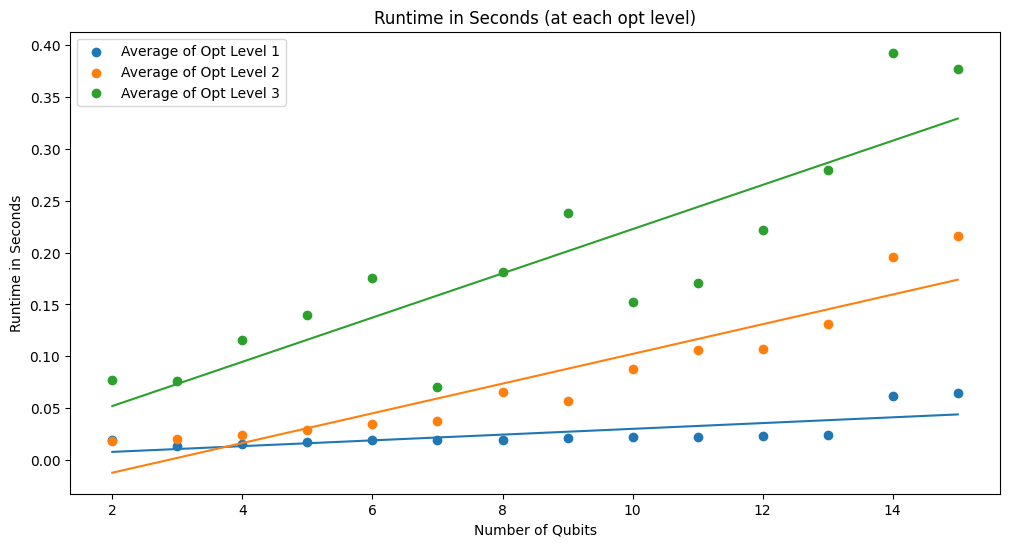

mean 1 [0.01926382500678301, 0.014075125003000722, 0.015147491602692752, 0.017324124998413026, 0.01897510001435876, 0.019495958200423047, 0.01977172479382716, 0.021807091805385426, 0.022433075006119907, 0.021966816805070268, 0.023719599994365126, 0.02423895019455813, 0.06153804999776184, 0.06454331659479066]
mean 2 [0.018015641602687538, 0.020515374798560516, 0.024332133401185275, 0.028676566603826358, 0.0352507583971601, 0.038004641805309804, 0.06607230840018019, 0.05732887479825877, 0.08823271640576422, 0.1057827334094327, 0.10737739159958437, 0.13086843360215425, 0.19610914979130029, 0.21583717518951745]
mean 3 [0.07701199178700335, 0.07597172500099987, 0.11610760019975715, 0.1400644581997767, 0.17583584139938466, 0.07060014979797416, 0.18148206659243443, 0.2380436333885882, 0.15241622499888763, 0.1705763331905473, 0.22183140859706327, 0.2795071500004269, 0.3924226418021135, 0.37629799980786627]


In [19]:
backend = FakeSherbrooke()
path_name = "Quantum Circuits/VQE" #Enter path name here
circuits, file_order = file_reader(path_name) # Place file name to preform benchmarking test on runtime
transpiled_circuits, level1_runtime, level2_runtime, level3_runtime, mean_transpile_times_1, mean_transpile_times_2, mean_transpile_times_3 = runtime_benchmarking(5, circuits, backend)

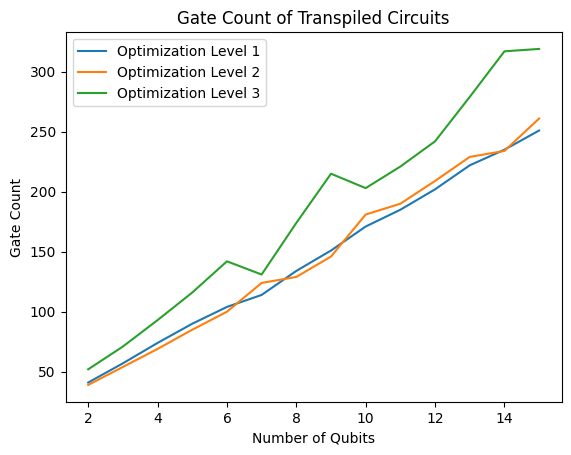

gate count level 1 [41, 57, 74, 90, 104, 114, 134, 151, 171, 185, 202, 222, 235, 251]
gate count level 2 [39, 54, 69, 85, 100, 124, 129, 146, 181, 190, 209, 229, 234, 261]
gate count level 3 [52, 71, 93, 116, 142, 131, 174, 215, 203, 221, 242, 279, 317, 319]
ratio 1 [7.2, 7.142857142857143, 7.222222222222222, 7.181818181818182, 7.0, 6.6, 6.882352941176471, 6.947368421052632, 7.142857142857143, 7.043478260869565, 7.08, 7.222222222222222, 7.103448275862069, 7.096774193548387]
ratio 2 [6.8, 6.714285714285714, 6.666666666666667, 6.7272727272727275, 6.6923076923076925, 7.266666666666667, 6.588235294117647, 6.684210526315789, 7.619047619047619, 7.260869565217392, 7.36, 7.481481481481482, 7.068965517241379, 7.419354838709677]
ratio 3 [9.4, 9.142857142857142, 9.333333333333334, 9.545454545454545, 9.923076923076923, 7.733333333333333, 9.235294117647058, 10.31578947368421, 8.666666666666666, 8.608695652173912, 8.68, 9.333333333333334, 9.931034482758621, 9.290322580645162]
The rate of change for 

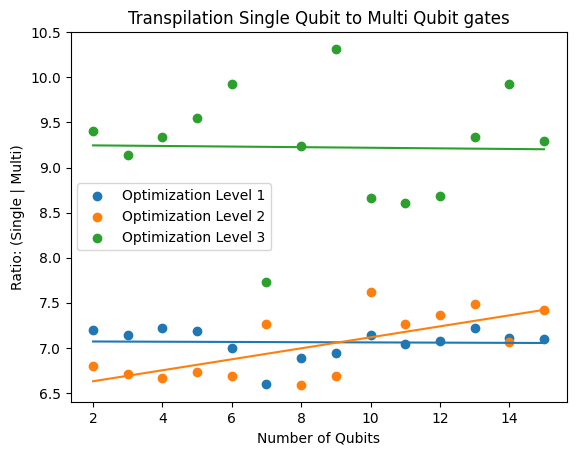

In [20]:
# Retrieves the return values from the benchmarking methods for the CSV file
level1_gatecount, level2_gatecount, level3_gatecount = gate_count(transpiled_circuits)
level1_ratio, level2_ratio, level3_ratio = single_multi_ratio_benchmarking(transpiled_circuits)
# entangling_gates_1, entangling_gates_2, entangling_gates_3 = find_num_entangled_gates(transpiled_circuits, circuits)

In [21]:
""" 
    Here we are creating the CSV file to store the results from our benchmarks.
    The data we are collecting includes:
    The name of the circuit 
    The average runtime
    The list of our 5 data points for to calculate our runtime average 
    The gate count
    The ratio of single to multi qubit gates
    The of number of swap gates
    The number of entangled gates
""" 

# Optimization Level 1 CSV
with open(f'{path_name}_level1.csv', 'w', newline='') as csvfile:
    # Below is the information we are trying to extract from our circuits
    fieldnames = ['Circuit Name',
                  ' Average Runtime: Level 1',
                  ' Run Times Level 1',
                  ' Gate Count: Level 1', 
                  ' Ratio: Level 1',
                  ' Entangling gate count 1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames) # calling the writer
    writer.writeheader() # Here we are creating the columns for our CSV file

    for file_name, avg_lvl_1, runtime_lvl_1,gate_count_lvl_1, ratio_lvl_1 in zip (file_order, mean_transpile_times_1, level1_runtime, level1_gatecount, level1_ratio):
        writer.writerow({'Circuit Name': file_name,
                         ' Average Runtime: Level 1': avg_lvl_1,
                         ' Run Times Level 1': runtime_lvl_1, 
                         ' Gate Count: Level 1': gate_count_lvl_1, 
                         ' Ratio: Level 1': ratio_lvl_1,
                         })

# Optimization Level 2 CSV
with open(f'{path_name}_level2.csv', 'w', newline='') as csvfile:
    # Below is the information we are trying to extract from our circuits
    fieldnames = ['Circuit Name',
                  ' Average Runtime: Level 2',
                  ' Run Times Level 2',
                  ' Gate Count: Level 2', 
                  ' Ratio: Level 2',
                  ' Entangling gate count 2']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames) # calling the writer
    writer.writeheader() # Here we are creating the columns for our CSV file

    for file_name, avg_lvl_2, runtime_lvl_2, gate_count_lvl_2, ratio_lvl_2 in zip(file_order, mean_transpile_times_2, level2_runtime, level2_gatecount, level2_ratio):
        writer.writerow({'Circuit Name': file_name,
                         ' Average Runtime: Level 2': avg_lvl_2,
                         ' Run Times Level 2': runtime_lvl_2, 
                         ' Gate Count: Level 2': gate_count_lvl_2, 
                         ' Ratio: Level 2': ratio_lvl_2,
                         })
        
# Optimization Level 3 CSV        
with open(f'{path_name}_level3.csv', 'w', newline='') as csvfile:
    # Below is the information we are trying to extract from our circuits
    fieldnames = ['Circuit Name',
                  ' Average Runtime: Level 3',
                  ' Run Times Level 3',
                  ' Gate Count: Level 3', 
                  ' Ratio: Level 3',
                  ' Entangling gate count 3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames) # calling the writer
    writer.writeheader() # Here we are creating the columns for our CSV file

    for file_name, avg_lvl_3, runtime_lvl_3, gate_count_lvl_3, ratio_lvl_3 in zip(file_order, mean_transpile_times_3, level3_runtime, level3_gatecount, level3_ratio):
        writer.writerow({'Circuit Name': file_name,
                         ' Average Runtime: Level 3': avg_lvl_3,
                         ' Run Times Level 3': runtime_lvl_3, 
                         ' Gate Count: Level 3': gate_count_lvl_3, 
                         ' Ratio: Level 3': ratio_lvl_3,
                         })
